# TO DOs

* probably need to increase line limit for bus 21-22 because it is always overloaded, even without a load
* probably need to increase the load and the generator size and rerun simulation
* add code to delete files from directories

# Set Up (imports including psspy)

In [ ]:
# uncomment to install for first time
# !pip install pandas
# !pip install numpy
# !pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/104.6 kB ? eta -:--:--
     --- ------------------------------------ 10.2/104.6 kB ? eta -:--:--
     -------------- ---------------------- 41.0/104.6 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 104.6/104.6 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.9/8.1 MB 27.7 MB/s eta 0:00:01
   ----------- ---------------------------- 2.3/8.1 MB 24.6 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 35.2 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 36.8 MB/s eta 0:00:01
   ---------------------------------------  8.0/8.1 MB 36.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 32.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/222.0 kB ? eta -:--:--
   ------------------------


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
print(sys.version) # should be 3.11.9

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [2]:
print(sys.path)

['c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311', '', 'C:\\Users\\lukas\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\psse_env_manager', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\win32', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\lukas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\Pythonwin']


In [3]:
PSSE_LOCATION = r"C:\Program Files\PTI\PSSE36\36.1\PSSPY311" # this is where the psspy module is located on my machine
sys.path.append(PSSE_LOCATION)
os.environ['PATH'] += ';' + PSSE_LOCATION

In [4]:
import psse3601
import psspy

# Import Case Data

In [5]:
# initialize system
psspy.psseinit(39)


 PSS(R)E Xplore Version 36
 Copyright (c) 1976-2025
 Siemens Industry, Inc.,
 Power Technologies International                            (PTI)
 This program is a confidential  unpublished  work  created  and  first
 licensed in 1976.  It is a trade secret which is the property of  PTI.
 All use,  disclosure,  and/or reproduction not specifically authorized
 by  PTI  is prohibited.   This  program is protected  under  copyright
 laws  of  non-U.S.  countries  and  by  application  of  international
 treaties.  All  Rights  Reserved  Under  The  Copyright  Laws.


           SIEMENS POWER TECHNOLOGIES INTERNATIONAL

    50 BUS POWER SYSTEM SIMULATOR--PSS(R)E Xplore-36.1.0

             INITIATED ON TUE, APR 29 2025  21:30


0

In [6]:
# read case
# psspy.read(0, "IEEE 39 bus - More Variables.RAW")
psspy.case("IEEE 39 bus - More Variables.sav")



 NEW ENGLAND TEST SYSTEM, 39 BUSES, 9 GENERATORS
 CREATED BY PABLO LEDESMA PABLOLE@ING.UC3M.ES

 The Saved Case in file c:\Users\lukas\OneDrive\Documents\Personal Projects\psse_powerflow\IEEE 39 bus - More Variables.sav was saved on SUN, APR 27 2025   9:47

 The following option settings are changed to the settings contained in the Saved Case File:

 ** BASE FREQUENCY option setting set to 60.0000

 ** NON-TRANSFORMER BRANCH PERCENT LOADING UNITS option setting set to MVA


0

# Testing

### Run load flow analysis

In [7]:
# run load flow analysis
psspy.fnsl([0,0,0,1,1,0,99,0]) # flat start newton-raphson load flow


  ITER       DELTAP      BUS         DELTAQ      BUS        DELTA/V/      BUS       DELTAANG      BUS
   0         0.0000(      5     )    0.0000(      8     )
                                                             0.00000(     25     )   0.00000(     30     )
   1         0.0000(     10     )    0.0000(      5     )
                                                             0.00000(      7     )   0.00000(     29     )
   2         0.0000(      5     )    0.0000(     10     )


 Reached tolerance in 2 iterations

 Largest mismatch:      0.00 MW      0.00 Mvar      0.00 MVA at bus 5 [5           1.0000]
 System total absolute mismatch:                    0.00 MVA

 SWING BUS SUMMARY:
   BUS#-SCT X-- NAME --X BASKV      PGEN     PMAX    PMIN      QGEN     QMAX    QMIN
     31     31          1.0000     571.3    750.0     0.0     363.9    800.0  -500.0


0

## Retrieve bus and machine data from base system

In [8]:
from itertools import groupby
from operator import itemgetter
attr_type = itemgetter(0)

def subsystem_info(name, attributes, sid=-1, inservice=True):
    """
    Returns requested attributes from the PSS(r)E subsystem API
    for the given subsystem id and subsystem element name.
    e.g. to retrieve bus attributes "NAME", "NUMBER" and "PU"
      
      subsystem_info('bus', ["NAME", "NUMBER", "PU"])
    where the 'bus' `name` argument comes from the original
    PSS(r)E subsystem API naming convention found in Chapter 8 of the
    PSS(r)E API.
    abusint  # bus
    amachint # mach
    aloadint # load
    Args:
      inservice [optional]: True (default) to list only information
         for in service elements;
      sid [optional]: list only information for elements in this
         subsystem id (-1, all elements by default).  
    
    """
    name = name.lower()
    gettypes = getattr(psspy, 'a%stypes' % name)
    apilookup = {
            'I': getattr(psspy, 'a%sint' % name),
            'R': getattr(psspy, 'a%sreal' % name),
            'X': getattr(psspy, 'a%scplx' % name),
            'C': getattr(psspy, 'a%schar' % name), }

    result = []
    ierr, attr_types = gettypes(attributes)

    df = pd.DataFrame()

    for k, group in groupby(zip(attr_types, attributes), key=attr_type):
      func = apilookup[k]
      strings = list(list(zip(*group))[1])
      ierr, res = func(sid, flag=1 if inservice else 2, string=strings)
      if len(strings) == 0:
        df[strings[0]] = res[0]
      else:
         for i in range(0, len(strings)):
            df[strings[i]] = res[i]
    return df


In [9]:
businfo = subsystem_info('bus', ['NUMBER', 'PU', 'Angle'], sid=-1)
businfo.head()

NUMBER        PU     Angle
0       1  1.051784 -0.149610
1       2  1.059875 -0.106962
2       3  1.056548 -0.156151
3       4  1.059186 -0.170671
4       5  1.073595 -0.153021

In [10]:
geninfo = subsystem_info('mach', ['NUMBER', 'ID', 'PMAX', 'PMIN', 'PGEN', 'QMAX', 'QMIN', 'QGEN'], sid=-1)
geninfo['BusNum-GenID'] = geninfo['NUMBER'].astype(str) + '-' + geninfo['ID'].astype(str)
geninfo.sort_values(by='PGEN', ascending=False).head()

NUMBER  ID    PMAX  PMIN    PGEN    QMAX    QMIN        QGEN BusNum-GenID
9      39  1   1500.0   0.0  1000.0  1500.0 -1000.0  -36.490406        39-1 
8      38  1   1000.0   0.0   830.0   800.0  -500.0   -0.473640        38-1 
2      32  1    750.0   0.0   650.0   800.0  -500.0    1.529850        32-1 
5      35  1    850.0   0.0   650.0   800.0  -500.0  167.044128        35-1 
3      33  1    750.0   0.0   632.0   800.0  -500.0   69.666168        33-1

In [11]:
loadinfo = subsystem_info('load', ['NUMBER', 'ID', 'MVAACT'], sid=-1)
loadinfo['MW'] = loadinfo['MVAACT'].apply(lambda x: x.real)
loadinfo['MVAR'] = loadinfo['MVAACT'].apply(lambda x: x.imag)
loadinfo['BusNum-LoadID'] = loadinfo['NUMBER'].astype(str) + '-' + loadinfo['ID'].astype(str)
loadinfo.sort_values(by='MVAACT', ascending=False).head()

NUMBER  ID                    MVAACT           MW        MVAR  \
30      39  1   1104.000000+ 250.000000j  1104.000000  250.000000   
19      20  1    680.000000+ 103.000000j   680.000000  103.000000   
7        8  1    522.000000+ 176.000000j   522.000000  176.000000   
3        4  1    500.000000+ 184.000000j   500.000000  184.000000   
15      16  1    329.399994+  32.299999j   329.399994   32.299999   

   BusNum-LoadID  
30         39-1   
19         20-1   
7           8-1   
3           4-1   
15         16-1

## Rune line limit report

In [12]:
psspy.report_output(2, r"line_limit_report.txt", [0,0])
psspy.rate_3(0,1,1,1,1,0,100.0,0)
psspy.report_output(1, "", [])


 Output completed


0

In [13]:
def clean_line_limit_report(df):
    # Show the first few rows to confirm
    old_cols = df.columns
    updated_cols = []
    for col in old_cols[0:5]:
        updated_cols.append('from_bus ' + col)
    for col in old_cols[5:10]:
        updated_cols.append('to_bus ' + col)
    updated_cols.extend(old_cols[10:])
    df.columns = updated_cols
    df.drop(['from_bus X--', 'to_bus X--.1', 'from_bus AREA','to_bus AREA.1', 'CKT'], axis=1, inplace=True)
    return df

line_limit_report = pd.read_fwf("line_limit_report.txt", skiprows=10)
line_limit_report = clean_line_limit_report(line_limit_report)
line_limit_report.head()

from_bus BUS#-SCT  from_bus NAME from_bus --X BASKV  to_bus BUS#-SCT.1  \
0                  1            NaN            1.0000*                  2   
1                  1            NaN             1.0000                 39   
2                  2            NaN            1.0000*                  3   
3                  2            NaN             1.0000                 25   
4                  3            NaN            1.0000*                  4   

   to_bus NAME.1 to_bus --X BASKV.1  LOADING   RATE1  PERCENT  RATE3  \
0            NaN             1.0000    125.5  1000.0     12.5    1.0   
1            NaN            1.0000*    169.5  1000.0     16.9    1.0   
2            NaN             1.0000    365.0  1000.0     36.5    1.0   
3            NaN            1.0000*    265.6  1000.0     26.6    1.0   
4            NaN             1.0000     80.8  1000.0      8.1    1.0   

   PERCENT.1  
0    12547.6  
1    16948.3  
2    36496.8  
3    26562.3  
4     8081.1

## Add a load and a generator to a bus

In [14]:
# save next load id and next generator id for each bus
bus_next_load_and_generator_ids = {}
bus_next_generator_id = {}
buses = businfo['NUMBER'].tolist()

for bus in buses:

    existing_load_id = loadinfo[loadinfo['NUMBER'] == bus]['ID'].max()
    if not pd.isna(existing_load_id):
        next_load_id = str(int(existing_load_id) + 1)
    else:
        next_load_id = str(1)

    existing_generator_id = geninfo[geninfo['NUMBER'] == bus]['ID'].max()
    if not pd.isna(existing_generator_id):
        next_generator_id = str(int(existing_generator_id) + 1)
    else:
        next_generator_id = str(1)
    
    bus_next_load_and_generator_ids[bus] = {'next_load_id': next_load_id, 'next_generator_id': next_generator_id}

In [15]:
bus = 1
id = '2'

p_load = 500
q_load = 0
psspy.load_data_3(bus, '2', [1, 1, 1, 1, 1], [p_load, q_load, 0, 0, 0, 0])

p_gen = 300
q_gen = 0
q_max = 300
q_min = 0
p_max = 400
p_min = 0
psspy.plant_data_4(bus, 0, [0, 0], [1, 100])
psspy.machine_data_3(bus, id, [1, 1, 0, 0, 0, 0, 0], [p_gen, q_gen, q_max, q_min, p_max, p_min])


 Load "2" at bus 1 [1           1.0000] added. Power flow data items with non-default values:
 X--DEFAULT---X  X---ACTUAL---X  DATA ITEM
    0.00000         500.000      PL

 Plant at bus 1 [1           1.0000] added. Data items with non-default values:
 X--DEFAULT---X  X---ACTUAL---X  DATA ITEM
          0               1      IREG

 Machine "2" at bus 1 [1           1.0000] added. Power flow data items with non-default values:
 X--DEFAULT---X  X---ACTUAL---X  DATA ITEM
    0.00000         300.000      PG
    9999.00         300.000      QT
   -9999.00         0.00000      QB
    9999.00         400.000      PT
   -9999.00         0.00000      PB


0

# Perform Looping

In [16]:
# load data params
p_load = 1000
q_load = 0

# generator data params
p_gen = 1000
q_gen = 0
q_max = 300
q_min = 0
p_max = 400
p_min = 0

In [17]:
# loop over each bus and run simulation
for load_bus in buses:

    # create directory
    directory = 'bus_{0}_simulations'.format(load_bus)
    if not os.path.isdir(directory):
        os.mkdir(directory)

    ###################################################################################################################################

    # start with original case
    # psspy.read(0, "IEEE 39 bus - More Variables.RAW")
    psspy.case("IEEE 39 bus - More Variables.sav")

    # add load to bus
    psspy.load_data_3(load_bus, bus_next_load_and_generator_ids[load_bus]['next_load_id'], [1, 1, 1, 1, 1], [p_load, q_load, 0, 0, 0, 0])

    # first, run power flow model without a generator
    psspy.fnsl([0,0,0,1,1,0,99,0]) # flat start newton-raphson load flow

    # save bus data
    businfo = subsystem_info('bus', ['NUMBER', 'PU', 'Angle'], sid=-1)
    businfo.to_csv(directory+r'\bus_data_no_generator.csv', index=False)

    # save generator data
    geninfo = subsystem_info('mach', ['NUMBER', 'ID', 'PMAX', 'PMIN', 'PGEN', 'QMAX', 'QMIN', 'QGEN'], sid=-1)
    geninfo['BusNum-GenID'] = geninfo['NUMBER'].astype(str) + '-' + geninfo['ID'].astype(str)
    geninfo.to_csv(directory+r'\gen_data_no_generator.csv', index=False)

    psspy.report_output(2, directory+r"\line_limit_report_no_generator.txt", [0,0])
    psspy.rate_3(0,1,1,1,1,0,100.0,0)
    psspy.report_output(1, "", [])
    line_limit_report = pd.read_fwf(directory+r"\line_limit_report_no_generator.txt", skiprows=10)
    line_limit_report = clean_line_limit_report(line_limit_report)
    line_limit_report.to_csv(directory+r'\line_limit_report_no_generator.csv', index=False)

    ###################################################################################################################################

    # now, loop over each bus and add a generator
    for gen_bus in buses:

        # start with original case
        psspy.read(0, "IEEE 39 bus - More Variables.RAW")

        # add load to bus
        psspy.load_data_3(load_bus, bus_next_load_and_generator_ids[load_bus]['next_load_id'], [1, 1, 1, 1, 1], [p_load, q_load, 0, 0, 0, 0])

        # add generator to bus
        psspy.plant_data_4(gen_bus, 0, [0, 0], [1, 100])
        psspy.machine_data_3(gen_bus, bus_next_load_and_generator_ids[gen_bus]['next_generator_id'], [1, 1, 0, 0, 0, 0, 0], [p_gen, q_gen, q_max, q_min, p_max, p_min])

        # run power flow model with generator
        psspy.fnsl([0,0,0,1,1,0,99,0]) # flat start newton-raphson load flow

        # save bus data
        businfo = subsystem_info('bus', ['NUMBER', 'PU', 'Angle'], sid=-1)
        businfo.to_csv(directory+r'\bus_data_with_generator_on_bus_{0}.csv'.format(gen_bus), index=False)

        # save generator data
        geninfo = subsystem_info('mach', ['NUMBER', 'ID', 'PMAX', 'PMIN', 'PGEN', 'QMAX', 'QMIN', 'QGEN'], sid=-1)
        geninfo['BusNum-GenID'] = geninfo['NUMBER'].astype(str) + '-' + geninfo['ID'].astype(str)
        geninfo.to_csv(directory+r'\gen_data_with_generator_on_bus_{0}.csv'.format(gen_bus), index=False)

        psspy.report_output(2, directory+r"\line_limit_report_with_generator_on_bus_{0}.txt".format(gen_bus), [0,0])
        psspy.rate_3(0,1,1,1,1,0,100.0,0)
        psspy.report_output(1, "", [])
        line_limit_report = pd.read_fwf(directory+r"\line_limit_report_with_generator_on_bus_{0}.txt".format(gen_bus), skiprows=10)
        line_limit_report = clean_line_limit_report(line_limit_report)
        line_limit_report.to_csv(directory+r"\line_limit_report_with_generator_on_bus_{0}.csv".format(gen_bus), index=False)


 NEW ENGLAND TEST SYSTEM, 39 BUSES, 9 GENERATORS
 CREATED BY PABLO LEDESMA PABLOLE@ING.UC3M.ES

 The Saved Case in file c:\Users\lukas\OneDrive\Documents\Personal Projects\psse_powerflow\IEEE 39 bus - More Variables.sav was saved on SUN, APR 27 2025   9:47

 Load "2" at bus 1 [1           1.0000] added. Power flow data items with non-default values:
 X--DEFAULT---X  X---ACTUAL---X  DATA ITEM
    0.00000         1000.00      PL

  ITER       DELTAP      BUS         DELTAQ      BUS        DELTA/V/      BUS       DELTAANG      BUS
   0        10.0000(      1     )    0.0000(      8     )
                                                             0.01229(      1     )   0.59428(      1     )
   1         0.2611(      1     )    1.1014(      6     )
                                                             0.02597(      8     )   0.04488(      1     )
   2         0.0229(      6     )    0.0366(      6     )
                                                             0.00097(      8 

# Analyze results

In [18]:
# loop over each bus and analyze simulation

# goal here is to pick best and worst scenarios in terms of line loading. Maybe also plot all line loading points into histogram, colored by simulation number.
# could also make a couple graphs about generator bus data (voltage pu, angle) and generator data (reactive power generation) and slack bus data

line_limit_summary_df = pd.DataFrame(columns=['load_bus', 'generator_bus', 'max_loading', 'median_loading', 'branches_overloaded', 'count_branches_overloaded'])
index=0

# for load_bus in buses:
for load_bus in buses:

    directory = 'bus_{0}_simulations'.format(load_bus)
    line_limits_df = pd.read_csv(directory+r'\line_limit_report_no_generator.csv')
    line_limits_df['Branch'] = line_limits_df['from_bus BUS#-SCT'].astype(str) + '-' + line_limits_df['to_bus BUS#-SCT.1'].astype(str)

    generator_bus = 'No generator'
    max_loading = line_limits_df['PERCENT'].max()
    median_loading = line_limits_df['PERCENT'].median()

    overloaded_df = line_limits_df[line_limits_df['PERCENT']>100]
    branches_overloaded = overloaded_df['Branch'].unique().tolist()
    count_branches_overloaded = overloaded_df.shape[0]

    line_limit_summary_df.loc[index] = [load_bus, generator_bus, max_loading, median_loading, branches_overloaded, count_branches_overloaded]
    index += 1

    for generator_bus in buses:

        line_limits_df = pd.read_csv(directory+r'\line_limit_report_with_generator_on_bus_{0}.csv'.format(gen_bus))
        line_limits_df['Branch'] = line_limits_df['from_bus BUS#-SCT'].astype(str) + '-' + line_limits_df['to_bus BUS#-SCT.1'].astype(str)

        max_loading = line_limits_df['PERCENT'].max()
        median_loading = line_limits_df['PERCENT'].median()

        overloaded_df = line_limits_df[line_limits_df['PERCENT']>100]
        branches_overloaded = overloaded_df['Branch'].unique().tolist()
        count_branches_overloaded = overloaded_df.shape[0]

        line_limit_summary_df.loc[index] = [load_bus, generator_bus, max_loading, median_loading, branches_overloaded, count_branches_overloaded]
        index += 1

In [66]:
line_limit_summary_df.sort_values(by=['count_branches_overloaded', 'max_loading'], ascending=[False, False]).head(10)

load_bus generator_bus  max_loading  median_loading  \
1080        28  No generator        148.8           40.65   
1081        28             1        148.8           44.85   
1082        28             2        148.8           44.85   
1083        28             3        148.8           44.85   
1084        28             4        148.8           44.85   
1085        28             5        148.8           44.85   
1086        28             6        148.8           44.85   
1087        28             7        148.8           44.85   
1088        28             8        148.8           44.85   
1089        28             9        148.8           44.85   

               branches_overloaded  count_branches_overloaded  
1080    [5-6, 17-27, 25-26, 28-29]                          4  
1081  [17-27, 21-22, 25-26, 28-29]                          4  
1082  [17-27, 21-22, 25-26, 28-29]                          4  
1083  [17-27, 21-22, 25-26, 28-29]                          4  
1084  [17-27, 21-22, 25-26, 28-29]                          4  
1085  [17-27, 21-22, 25-26, 28-29]                          4  
1086  [17-27, 21-22, 25-26, 28-29]                          4  
1087  [17-27, 21-22, 25-26, 28-29]                          4  
1088  [17-27, 21-22, 25-26, 28-29]                          4  
1089  [17-27, 21-22, 25-26, 28-29]                          4

In [23]:
line_limit_summary_df.to_csv('final_line_limit_summary.csv', index=False)

Text(0.5, 1.0, 'generator bus vs count branches overloaded')

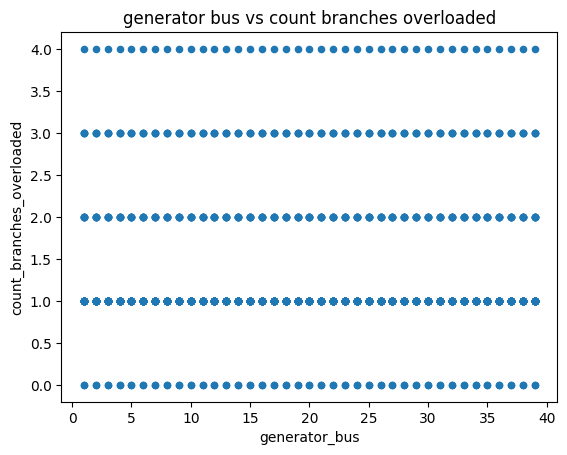

In [70]:
line_limit_summary_df[line_limit_summary_df['generator_bus']!='No generator'].plot(x='generator_bus', y='count_branches_overloaded', kind='scatter')
plt.title('generator bus vs count branches overloaded')

Text(0.5, 1.0, 'median loading % by max loading %')

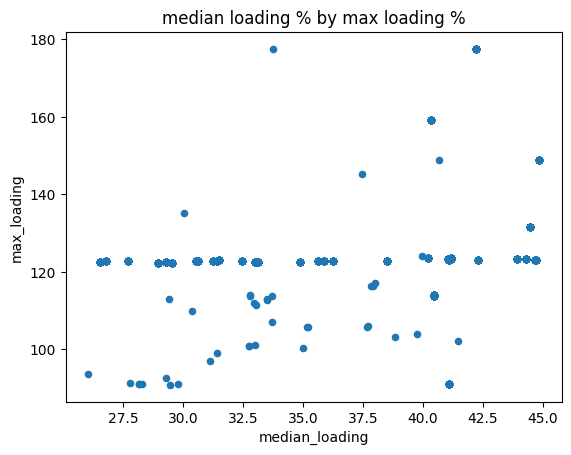

In [61]:
line_limit_summary_df.plot(x='median_loading', y='max_loading', kind='scatter')
plt.title(r'median loading % by max loading %')

Text(0.5, 1.0, 'median loading % by count branches overloaded')

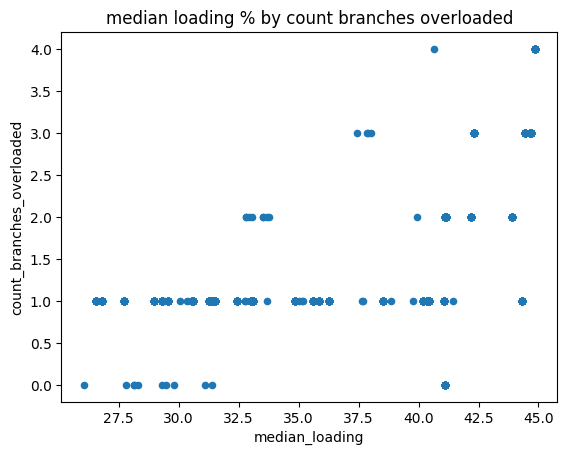

In [62]:
line_limit_summary_df.plot(x='median_loading', y='count_branches_overloaded', kind='scatter')
plt.title(r'median loading % by count branches overloaded')

Text(0.5, 1.0, 'max loading % by count branches overloaded')

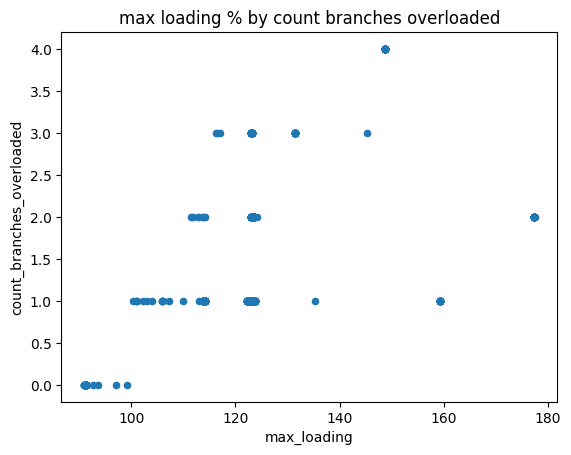

In [63]:
line_limit_summary_df.plot(x='max_loading', y='count_branches_overloaded', kind='scatter')
plt.title(r'max loading % by count branches overloaded')

In [38]:
branches_overloaded_valcounts = line_limit_summary_df['branches_overloaded'].value_counts().to_frame().reset_index()
branches_overloaded_valcounts.head()

branches_overloaded  count
0                [21-22]    936
1         [16-19, 21-22]    156
2  [17-27, 21-22, 25-26]    117
3                     []     88
4                [22-23]     78

In [47]:
branches_overloaded_df = pd.DataFrame(columns=['branch', 'count_overloads'])

index=0
for i in range(0, branches_overloaded_valcounts.shape[0]):
    row = branches_overloaded_valcounts.iloc[i]
    if len(row[0]) == 0:
        branches_overloaded_df.loc[index] = ['None', row[1]]
        index += 1
    else:
        for branch in row[0]:
            branches_overloaded_df.loc[index] = [branch, row[1]]
            index += 1
branches_overloaded_df.sort_values(by='count_overloads', ascending=False).head()

C:\Users\lukas\AppData\Local\Temp\ipykernel_5640\2254330433.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(row[0]) == 0:
C:\Users\lukas\AppData\Local\Temp\ipykernel_5640\2254330433.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for branch in row[0]:
C:\Users\lukas\AppData\Local\Temp\ipykernel_5640\2254330433.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  branches_overloaded_df.loc[index] = [branch, row[1]]
C:

branch  count_overloads
0  21-22              936
1  16-19              156
2  21-22              156
3  17-27              117
4  21-22              117

In [57]:
branches_overloaded_summary_df = pd.DataFrame(columns=['branch', 'count_overloads'])
index=0
for branch in branches_overloaded_df['branch'].unique().tolist():
    sum_overloads = branches_overloaded_df[branches_overloaded_df['branch']==branch]['count_overloads'].sum()
    branches_overloaded_summary_df.loc[index] = [branch, sum_overloads]
    index += 1
branches_overloaded_summary_df = branches_overloaded_summary_df.sort_values(by='count_overloads', ascending=False)
branches_overloaded_summary_df.head()

branch  count_overloads
0  21-22             1366
2  17-27              200
1  16-19              160
3  25-26              160
4   None               88

In [64]:
branches_overloaded_summary_df.shape

(12, 2)

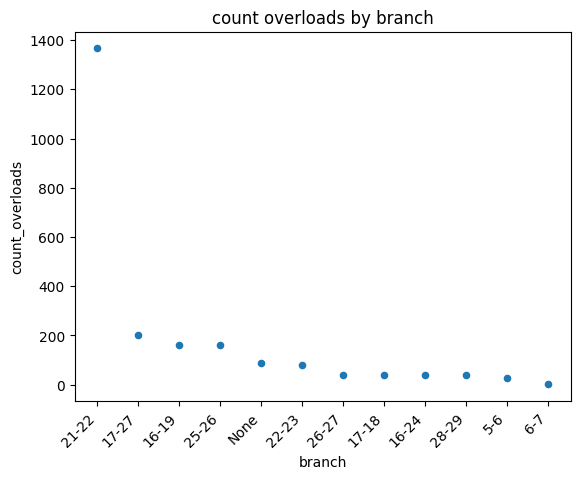

In [65]:
branches_overloaded_summary_df.plot(x='branch', y='count_overloads', kind='scatter', )
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align right
plt.title('count overloads by branch')
plt.show()